In [1]:
#imports (same as tuto ML)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_20newsgroups
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline

# Question 1: Propensity score matching

We preform a naive data analysis using plots.

In [2]:
#import the data set
lalonde_df = pd.read_csv('lalonde.csv')
#give a first look
lalonde_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1. A naive analysis

It is very hard to determine what a "naive" researcher would think or try to determine from this data. However, we can easily imagine that the first thing he would do is split the salary (_['re78']_) data into 2 sets: treated and untreated.

In [ ]:
treated_salary = lalonde_df[lalonde_df.treat == 1]['re78']
untreated_salary = lalonde_df[lalonde_df.treat == 0]['re78']

**i - Visualizing the data:**

We suppose that the first step of the analysis would be to plot the data to be able to have a visual summary of what it says.

_**Note:** we used the [following StackOverflow code](https://stackoverflow.com/questions/8822370/plot-line-graph-from-histogram-data-in-matplotlib) to compute the histograms as a continuous function._

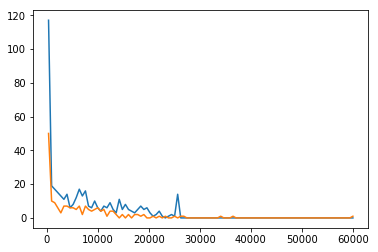

In [37]:
import pylab as p

val_range = (0, np.maximum(treated_salary.max(), untreated_salary.max()))

u_y, u_binEdges = np.histogram(untreated_salary, bins = 100, range=val_range)
u_centers = 0.5*(u_binEdges[1:] + u_binEdges[:-1])
p.plot(u_centers, u_y, '-')

t_y, t_binEdges = np.histogram(treated_salary, bins = 100, range=val_range)
t_centers = 0.5*(t_binEdges[1:] + t_binEdges[:-1])
p.plot(t_centers, t_y, '-')

p.show()

##### First insights:

By looking at the graph, we see a very similar distribution for both functions, except for the outliers. However, we suppose that the researcher would not care about the outliers as much as he would about the shape of the functions. They are not even visible in the plot he would draw.

Another very visible element is the fact that the function of the treated group's salaries is shifted to the bottom. Very quickly (cf paragraph below), a simple explanation arises: the number of members in the treated group is lower.

**ii - Describing the numbers**

Thus, we determined that he would only look at the basic descriptions of the data (mean, std and 5 number summary). Even though there is a "count" column in the method we use, we supposed that such a reasearcher would not get in insights from the difference between the 2 groups but solely on the description information.

In [5]:
lalonde_df.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


From the numbers above, we assume that the research would extract the following information from the data :

- The untreated group has more people.
- The untreated group's salaries are homogeneous compared to the treated group's salaries (there is a smaller deviation). Moreover, the untreated group's salaries are higher (higher mean).
- However, the max salary in the treated group is 3x higher! The 1st quartile is also twice higher on the treated group.
- Finally, we have that the second and third quartiles are higher in the first group.

###### Second insights:

By looking at these numbers the researcher would assume that the treatment only helps the poorer and richer people while being a burden for the "middle class". Moreover, it has a negative impact according to the basic statistics (the group's incomes are lower in average and allocated less efficiently according to the standard deviation).

**iii - Looking at the numbers:**

As a naive researcher often bases his insights on visual representations, we assume he would want to look at the boxplts corresponding to each group to be able to compare them more easily.

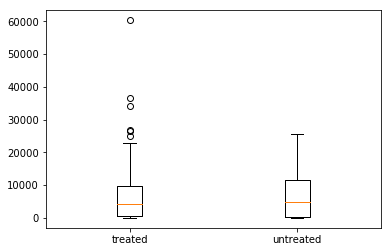

In [7]:
plt.boxplot([treated_salary, untreated_salary], labels=['treated', 'untreated'])
plt.show()

##### Third insights :

By discarding the outliers (points above the first box which do not represent a lot as they only represent the richest people), the researcher is clearly comforted in his past insights, allowing him to formulate a conclusion.

**Conclusion**:

By merging all of the insights the researcher has drawn from the 3 steps of his analysis, he can conclude that **the treatment is ineffective**. Even though salary distributions are similar in both cases, the treated group has in average a lower salary (and only a handful of rich people get lucky). This is shown by the boxplot: the whiskers extend higher in the untreated group.

### 2. A closer look at the data

We look more closely at the data, building a histogram for every column. Maybe not throw id as important, use new DFs each time (and throw at the appropriate time)

In [9]:
#distinct id is useless
del lalonde_df['id']

We only care about intervals (makes sense to represent them using histograms). We also include boxplots (visual representation of the 5 nbr summary)

Histogram and 5 number summary for column :  age

        count       mean        std   min   25%   50%   75%   max
treat                                                           
0      429.0  28.030303  10.786653  16.0  19.0  25.0  35.0  55.0
1      185.0  25.816216   7.155019  17.0  20.0  25.0  29.0  48.0


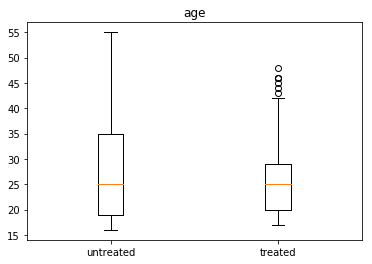

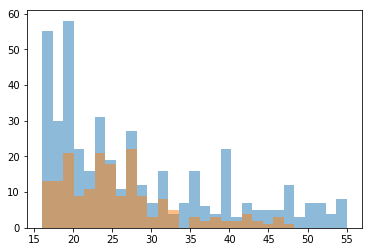

Histogram and 5 number summary for column :  educ

        count       mean       std  min  25%   50%   75%   max
treat                                                        
0      429.0  10.235431  2.855238  0.0  9.0  11.0  12.0  18.0
1      185.0  10.345946  2.010650  4.0  9.0  11.0  12.0  16.0


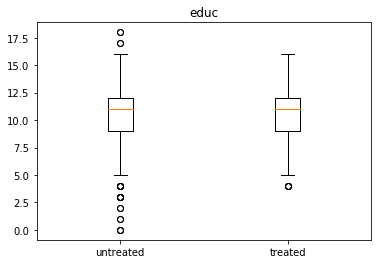

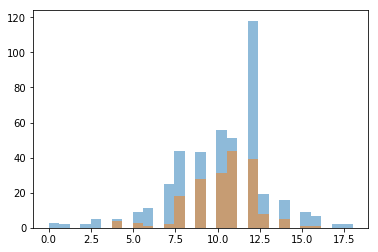

Histogram and 5 number summary for column :  re74

        count         mean          std  min  25%       50%       75%       max
treat                                                                         
0      429.0  5619.236506  6788.750796  0.0  0.0  2547.047  9277.128  25862.32
1      185.0  2095.573689  4886.620353  0.0  0.0     0.000  1291.468  35040.07


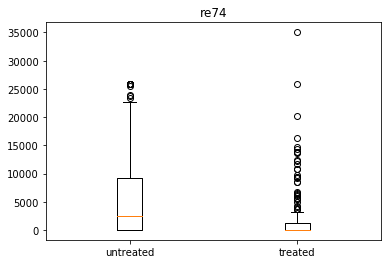

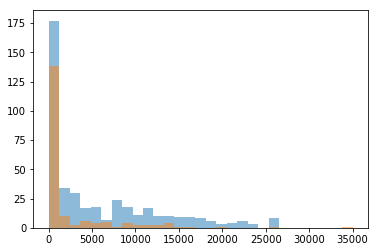

Histogram and 5 number summary for column :  re75

        count         mean          std  min  25%       50%       75%       max
treat                                                                         
0      429.0  2466.484443  3291.996183  0.0  0.0  1086.726  3881.419  18347.23
1      185.0  1532.055314  3219.250870  0.0  0.0     0.000  1817.284  25142.24


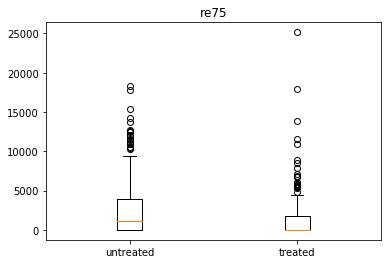

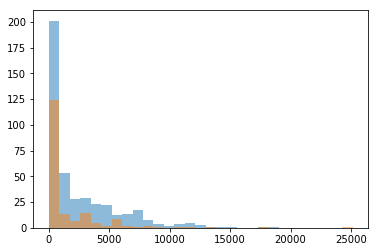

Histogram and 5 number summary for column :  re78

        count         mean          std  min       25%       50%        75%  \
treat                                                                        
0      429.0  6984.169742  7294.161791  0.0  220.1813  4975.505  11688.820   
1      185.0  6349.143530  7867.402218  0.0  485.2298  4232.309   9642.999   

            max  
treat            
0      25564.67  
1      60307.93  


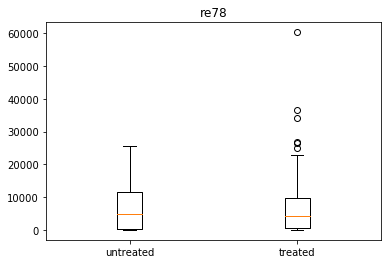

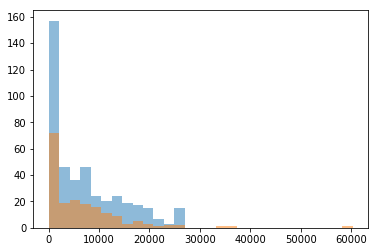

In [10]:
intervals = ['age', 'educ', 're74', 're75', 're78']

for col in intervals:
    print('Histogram and 5 number summary for column : ', col)
    print('\n',lalonde_df.groupby('treat')[col].describe())
    plt.title(col)
    plt.boxplot([lalonde_df[untreat][col], lalonde_df[treat][col]], labels=['untreated', 'treated'])
    plt.figure()
    bins = np.linspace(np.min(lalonde_df[col]),np.max(lalonde_df[col]), 30)
    plt.hist(lalonde_df[untreat][col], bins,alpha=0.5)
    plt.hist(lalonde_df[treat][col],bins, alpha=0.5)
    plt.show()

We note different distributions (need to compare each one alone). Salaries are all long tailed, education is a gaussian, but age has no apparent distribution (maybe Poisson ?!).

Regarding categorical data, we should look at rates (makes much more sense than looking at just the numbers). Thus we define the rates for race, degree and marriage depending on each treat to be able to compare them (pie charts ? we need smthng visual).

In [11]:
#Implement pie chart mentioned above

We also decide to look at the correlation between the variables (is this the best method to do it ? Not better doing it for each treat alone ?). 
--> Interesting, but explain why ? And most importantly, explain what we see (degrees are not - linearly - linked to race, all salaries are linked, other obvious stuff like link between educ & degree or age & marriage)

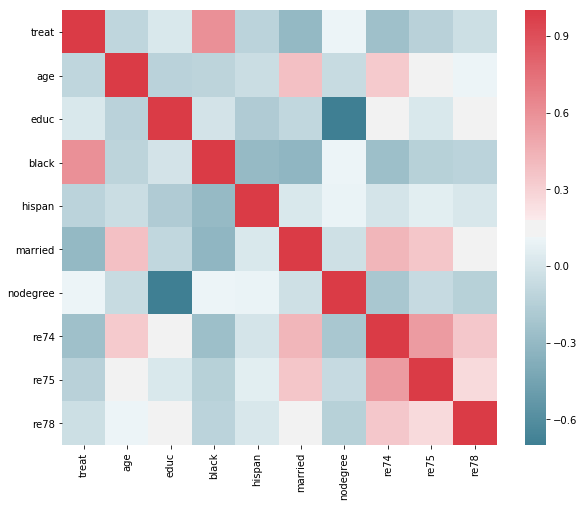

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = lalonde_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### 3. A propsensity score model

In [13]:
prop_table = lalonde_df
del prop_table['re78']

In [14]:
X = prop_table.iloc[:, 1:]
y = prop_table.iloc[:, :1]
y = np.ravel(y)

In [15]:
logistic = LogisticRegression()
logistic.fit(X, y)
logistic.score(X, y)

0.80781758957654726

Is propensity really that simple ? Cf formula in the course (depends on $\pi_i = p(Z = 1 \mid x)$)
==> Doesn't work, here we have the probability of success, need to find the exact thing to do (look with Sas & Leo)

### 4. Balancing the dataset via matching

### 5. Balancing the groups further


### 6. A less naive analysis

# Question 2: Applied ML

## 1.

Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


In [16]:
# Test and training set are given already, need to choose how to get validation set. Remove as proposed by tutorial
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [17]:
# We have the data as a list, transform it to a pandas DF. Not sure if needed though.
train_DF = pd.DataFrame(newsgroups_train.data)
test_DF = pd.DataFrame(newsgroups_test.data)
train_DF.head()

,0
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."


## 2.

Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.
